# Covarying neighborhood analysis demo

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cna
np.random.seed(0)

/PHShome/yr073/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


## Minimal working example

Transforming to str index.


qcd NAM not found; computing and saving
	taking step 1
	median excess kurtosis: 13.050081575691678
	taking step 2
	median excess kurtosis: 9.740420558616929
	taking step 3
	median excess kurtosis: 3.164686377925819
	taking step 4
	median excess kurtosis: 0.2183676785797266
stopping after 4 steps
throwing out neighborhoods with maxbatchcorr2 >= 0.041654671665214
keeping 8130 neighborhoods
covariate-adjusted NAM not found; computing and saving
	with ridge 100000.0 median max sq batch correlation = 0.019301201146109614
computing SVD


/data/srlab1/yakir/py/cna/cna/tools/_association.py:73: UserWarning: global association p-value attained minimal possible value. Consider increasing Nnull
  warnings.warn('global association p-value attained minimal possible value. '+\


computing neighborhood-level FDRs


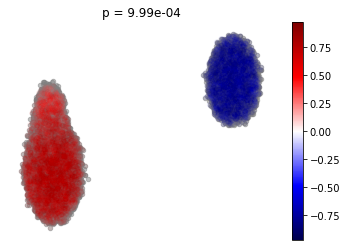

In [15]:
# read in dataset
d = cna.read('data.h5ad')

# perform association test for case/ctrl status
res = cna.tl.association(d, d.samplem.case, covs=d.samplem[['male']], batches=d.samplem.batch)

# visualize the results
cna.pl.umap_ncorr(d, res,
            scatter0={'alpha':0.5, 's':20},
            scatter1={'alpha':0.05, 's':20})
plt.title('p = {:.2e}'.format(res.p))
plt.show()

Color corresponds to correlation of each neighborhood to the outcome of interest, with neighborhoods that don't pass FDR 5% shown in gray. As this plot shows, cases have a greater abundance of cells from the left-hand cluster relative to controls.

covariate-adjusted NAM not found; computing and saving
	with ridge 100000.0 median max sq batch correlation = 0.031511718166384955
	with ridge 10000.0 median max sq batch correlation = 0.03150416889783558
	with ridge 1000.0 median max sq batch correlation = 0.031428813641394326
	with ridge 100.0 median max sq batch correlation = 0.030689041920174763
	with ridge 10.0 median max sq batch correlation = 0.024512159722006807
computing SVD


/data/srlab1/yakir/py/cna/cna/tools/_association.py:73: UserWarning: global association p-value attained minimal possible value. Consider increasing Nnull
  warnings.warn('global association p-value attained minimal possible value. '+\


computing neighborhood-level FDRs


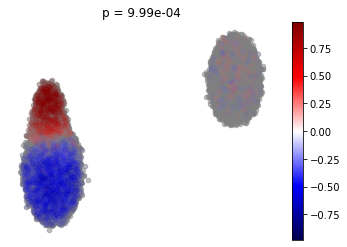

In [14]:
# perform association test for male sex
res = cna.tl.association(d, d.samplem.male, covs=d.samplem[['case']], batches=d.samplem.batch)

# visualize the results
cna.pl.umap_ncorr(d, res,
            scatter0={'alpha':0.5, 's':20},
            scatter1={'alpha':0.05, 's':20})
plt.title('p = {:.2e}'.format(res.p))
plt.show()

It's now clear that a sub-population of the left-hand cluster is more abundant in males. CNA automatically picked up on this without needing to be given a resolution parameter.

Note that it looks like some cells in the right-hand cluster pass our FDR threshold of 5%. However, these cells comprise only ~6% of the cells that pass the threshold and so are likely false discoveries.

## Longer version

In [2]:
d = cna.read('data.h5ad')

Transforming to str index.


d.X is the raw data, d.obs is cell-level meta-data, d.var contains feature-level metadata, d.samplem contains sample-level metadata, and d.uns contains things like the UMAP coordinates, the PCA coordinates, etc. Take a quick look at these objects if you want.

In [ ]:
d.X.shape

In [ ]:
d.samplem.head()

In [ ]:
d.obs

Let's do the association analysis and go over the results in detail

In [8]:
res = cna.tl.association(d, d.samplem.case, covs=d.samplem[['male']], batches=d.samplem.batch)

qcd NAM not found; computing and saving
	taking step 1
	median excess kurtosis: 13.050081575691678
	taking step 2
	median excess kurtosis: 9.740420558616929
	taking step 3
	median excess kurtosis: 3.164686377925819
	taking step 4
	median excess kurtosis: 0.2183676785797266
stopping after 4 steps
throwing out neighborhoods with maxbatchcorr2 >= 0.041654671665214
keeping 8130 neighborhoods
covariate-adjusted NAM not found; computing and saving
	with ridge 100000.0 median max sq batch correlation = 0.019301201146109614
computing SVD


/data/srlab1/yakir/py/cna/cna/tools/_association.py:73: UserWarning: global association p-value attained minimal possible value. Consider increasing Nnull
  warnings.warn('global association p-value attained minimal possible value. '+\


computing neighborhood-level FDRs


The res object returned by the association function contains the following fields:
1. p is the p-value for association
1. k is the number of PCs used (automatically selected in a data-dependent way)
1. ncorrs is the vector of neighborhood-level correlations to the outcome
1. fdr_10p_t and fdr_5p_t tell you what threshold on np.abs(ncorrs) will provide you FDRs of 10% and 5% respectively
1. fdrs contains information on neighborhood-level FDRs at different thresholds
1. kept is a boolean vector telling you which cells passed qc. So, e.g., ncorrs is of length kept.sum().
1. r2 is the global r2 that the model achieved with all PCs together
1. r2_perpc is the r2 achieved by each pc on its own
1. beta is the coefficient vector, one coefficient per PC
1. yresid and yresid_hat are the phenotype and the predicted phenotype, both with covariates and batch residualized out, in case you want to eyeball the plot

The kurtosis numbers in the output above say how 'outlier-y' the neighborhood abundances are at each step in our diffusion. The algorithm stops when these numbers stop going down quickly. But if on other data sets you're seeing that it stops when kurtosis is still very high (like above 10), that's likely a sign that the data aren't qc'd properly or are otherwise unsuitable.

The other objects generated by the association function are the NAM itself as well as its SVD. These can be found in the following objects
1. d.uns['NAM.T'] is the transpose of the NAM (neighborhoods by samples)
1. d.uns['NAM_sampleXpc'] is the right principal components of the NAM
1. d.uns['NAM_nbhdXpc'] is the left principal components of the NAM
1. d.uns['NAM_svs'] is the squared singular values of the NAM

More info and demos on these in future versions of the tutorial!

## How to pre-process data into correct format

Let's pretend we had a new data set (with metadata stored per cell rather then per-sample, as is common)...

In [3]:
X = d.X
cell_meta = d.obs
sampleXmeta = d.samplem
cell_meta['batch'] = np.repeat(d.samplem.batch.values, 200)
cell_meta['case'] = np.repeat(d.samplem.case.values, 200)
cell_meta['male'] = np.repeat(d.samplem.male.values, 200)
del sampleXmeta

...and now convert it into the correct format

In [7]:
import multianndata as mad
import scanpy as sc

# initialize a MultiAnnData object
d = mad.MultiAnnData(X=X, obs=cell_meta)

# copy the cell-level metadata into sample-level metadata
d.obs_to_sample(['batch', 'case', 'male'])

# compute the UMAP nearest neighbor graph and UMAP coordinates
sc.pp.neighbors(d)
sc.tl.umap(d)

# to save the pre-processed data
# d.write('test.h5ad')

/PHShome/yr073/anaconda3/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../PHShome/yr073/anaconda3/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/PHShome/yr073/anaconda3/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../PHShome/yr073/ana